<a href="https://colab.research.google.com/github/kumaramar5526/Task_10_DA/blob/main/Task_10_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip install requests beautifulsoup4 pandas matplotlib lxml


Task 10: Scrape and Analyze Job Listings for Data Analyst Roles



In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
from collections import Counter
import random
import sys
from datetime import datetime

# Config

In [11]:
BASE_SEARCH_URL = "https://internshala.com/internships/data+analyst-internship"
HEADERS = {
    "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                   "AppleWebKit/537.36 (KHTML, like Gecko) "
                   "Chrome/119.0.0.0 Safari/537.36"),
    "Accept-Language": "en-US,en;q=0.9"
}
PAGES_TO_SCRAPE = 3        # number of pages to attempt
REQUEST_SLEEP = 1.5       # seconds between requests
OUTPUT_CSV = "scraped_data_analyst_jobs.csv"
USE_MOCK_ON_FAIL = True   # fallback to mock data if scraping blocked

# Helper: generate mock data

In [16]:
def generate_mock_data(n=60):
    """Return a DataFrame of mock job rows (title, company, location, salary, skills)."""
    titles = [
        "Data Analyst Intern", "Junior Data Analyst", "Business Data Analyst",
        "Data Science Intern", "Data Analyst", "Analytics Intern"
    ]
    companies = [
        "Alpha Tech", "Beta Analytics", "Gamma Labs", "Delta Solutions",
        "Epsilon Corp", "Zeta Systems", "Theta Data"
    ]
    locations = ["Bengaluru", "Pune", "Hyderabad", "Chennai", "Mumbai", "Noida", "Gurugram"]
    salary_samples = ["₹10,000 - ₹20,000/month", "Stipend: ₹15,000", "Not Specified", "₹8,000"]
    skill_pools = [
        ["python", "sql", "excel", "tableau"],
        ["sql", "excel", "power bi", "statistics"],
        ["python", "pandas", "matplotlib", "sql"],
        ["excel", "tableau", "communication", "sql"],
        ["python", "sql", "machine learning", "power bi"]
    ]

    rows = []
    for i in range(n):
        skills = random.choice(skill_pools)
        descr_skills = ", ".join(random.sample(skills, k=min(len(skills), random.randint(2,4))))
        rows.append({
            "title": random.choice(titles),
            "company": random.choice(companies),
            "location": random.choice(locations),
            "salary": random.choice(salary_samples),
            "skills": descr_skills
        })
    df = pd.DataFrame(rows)
    return df

# Scraping functions

In [17]:
def fetch_page(url, headers=HEADERS):
    """Return response.text for url, raise an informative exception on HTTP errors."""
    resp = requests.get(url, headers=headers, timeout=15)
    resp.raise_for_status()
    return resp.text

In [18]:
def parse_internshala_search_page(html):
    """
    Parse an Internshala search result page and return list of job dicts.
    NOTE: site structure can change; this uses heuristics and multiple fallbacks.
    """
    soup = BeautifulSoup(html, "lxml")

    # Internshala lists internships typically inside cards. We'll search for a few candidate containers.
    job_cards = soup.select("div.internship_meta, div.individual_internship, div.other_internship_card") \
                or soup.find_all("div", class_=re.compile("internship"))
    results = []

    for card in job_cards:
        try:
            # Try different selectors in order of likelihood.
            title_tag = card.find(["a", "h3", "h2"], class_=re.compile("(heading|profile|internship_name|title)")) \
                        or card.find("a", href=True)
            title = title_tag.get_text(separator=" ").strip() if title_tag else "Not Specified"

            company_tag = card.find("a", class_=re.compile("(company|name)")) \
                          or card.find("div", class_=re.compile("(company|org)"))
            company = company_tag.get_text(separator=" ").strip() if company_tag else "Not Specified"

            location_tag = card.find("i", class_=re.compile("location")) \
                           or card.find("span", class_=re.compile("location")) \
                           or card.find("div", class_=re.compile("location"))
            location = location_tag.get_text(separator=" ").strip() if location_tag else "Not Specified"

            stipend_tag = card.find("span", class_=re.compile("stipend|salary|paid")) \
                         or card.find("div", class_=re.compile("stipend"))
            salary = stipend_tag.get_text(separator=" ").strip() if stipend_tag else "Not Specified"

            # skills/short description
            desc_tag = card.find("div", class_=re.compile("details|about|internship_meta|short")) \
                       or card.find("ul")
            skills = desc_tag.get_text(separator=" ").strip() if desc_tag else "Not Specified"

            # Normalizing whitespace
            skills = re.sub(r"\s+", " ", skills)
            results.append({
                "title": title,
                "company": company,
                "location": location,
                "salary": salary,
                "skills": skills
            })
        except Exception:
            # skip malformed card
            continue

    return results

In [19]:
def scrape_internshala(pages=PAGES_TO_SCRAPE):
    """Scrape multiple pages from Internshala and return a DataFrame."""
    all_jobs = []
    for p in range(1, pages + 1):
        # Internshala uses page numbers in query params like '?page=2' (if not, check the actual site)
        url = BASE_SEARCH_URL + (f"?page={p}" if p > 1 else "")
        print(f"Fetching page {p} => {url}")
        try:
            html = fetch_page(url)
            jobs = parse_internshala_search_page(html)
            print(f"  -> Found {len(jobs)} items on page {p}")
            all_jobs.extend(jobs)
        except requests.exceptions.HTTPError as he:
            print(f"Error fetching page {p}: {he}", file=sys.stderr)
            raise
        except Exception as e:
            print(f"Unexpected error fetching page {p}: {e}", file=sys.stderr)
            raise
        time.sleep(REQUEST_SLEEP)
    df = pd.DataFrame(all_jobs)
    return df


# Data cleaning & skill extraction

In [20]:
def clean_dataframe(df):
    """Clean whitespace and fill missing values."""
    # Ensure all expected columns exist
    for col in ["title", "company", "location", "salary", "skills"]:
        if col not in df.columns:
            df[col] = "Not Specified"
    # Strip whitespace
    for col in ["title", "company", "location", "salary", "skills"]:
        df[col] = df[col].astype(str).apply(lambda x: x.strip())
        df[col] = df[col].replace({"": "Not Specified", "nan": "Not Specified", "None": "Not Specified"})
    return df


In [21]:
def extract_skills_from_text(text):
    """
    Use regex heuristics to find probable skill tokens in a job description string.
    Returns a list of normalized skills (lowercase).
    """
    # Common skill keywords to look for (expand as needed)
    skill_keywords = [
        "python", "sql", "excel", "tableau", "power bi", "powerbi", "r", "pandas",
        "numpy", "matplotlib", "seaborn", "spark", "hadoop", "sas", "statistical",
        "machine learning", "ml", "aws", "gcp", "bigquery", "lookml", "powerpoint",
        "communication", "data visualization", "analytics", "business intelligence",
        "sql-server", "postgresql", "mysql"
    ]
    s = text.lower()
    found = []
    # check multi-word first
    for kw in sorted(skill_keywords, key=lambda x: -len(x)):
        if kw in s:
            # normalize
            k = kw.replace(" ", " ")
            found.append(k)
            # remove to avoid duplicate matches
            s = s.replace(kw, " ")
    # fallback: grab capitalized tokens or words that look like skill names (letters/numbers)
    words = re.findall(r"\b[a-zA-Z\+\#]{2,}\b", text)
    # Add high-frequency single tokens that look like skills
    for w in words:
        lw = w.lower()
        if lw in ["python", "sql", "r", "excel", "tableau", "power", "powerbi", "pandas", "numpy"]:
            if lw not in found:
                found.append(lw)
    # final dedupe
    found_norm = []
    for x in found:
        xn = re.sub(r"\s+", " ", x.strip())
        if xn and xn not in found_norm:
            found_norm.append(xn)
    return found_norm

# Analysis & Visualization

In [22]:
def analyze_and_plot(df, top_n_locations=5, top_n_skills=10, save_plots=True):
    """Perform analysis, print summary, and produce simple plots (bar and pie)."""
    df = clean_dataframe(df)

    total_jobs = len(df)
    print(f"\n✅ Total jobs available in dataset: {total_jobs}")

    # Top locations
    top_locations = df["location"].value_counts().head(top_n_locations)
    print("\n📍 Top locations:")
    print(top_locations.to_string())

    # Skills extraction: build a counter
    all_skills = []
    for s in df["skills"].fillna("Not Specified"):
        list_sk = extract_skills_from_text(s)
        all_skills.extend(list_sk)

    skill_counts = Counter(all_skills)
    top_skills = skill_counts.most_common(top_n_skills)
    print("\n💡 Top skills (extracted):")
    for skill, cnt in top_skills:
        print(f"  - {skill}: {cnt}")

    # Save summary to file
    summary = {
        "total_jobs": total_jobs,
        "top_locations": top_locations.to_dict(),
        "top_skills": {k: v for k, v in top_skills}
    }

    # Plots
    if total_jobs > 0:
        # Bar plot for top locations
        plt.figure(figsize=(8, 5))
        top_locations.plot(kind="bar")
        plt.title("Top Job Locations")
        plt.xlabel("Location")
        plt.ylabel("Number of jobs")
        plt.tight_layout()
        if save_plots:
            fname = f"top_locations_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
            plt.savefig(fname)
            print(f"\nSaved location bar chart to: {fname}")
        plt.show()

        # Pie for top skills
        if len(top_skills) > 0:
            skills_df = pd.DataFrame(top_skills, columns=["skill", "count"]).set_index("skill")
            plt.figure(figsize=(6, 6))
            skills_df.plot(kind="pie", y="count", autopct="%1.1f%%", legend=False)
            plt.title("Top Skills (extracted)")
            plt.ylabel("")
            plt.tight_layout()
            if save_plots:
                fname = f"top_skills_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
                plt.savefig(fname)
                print(f"Saved skills pie chart to: {fname}")
            plt.show()
    else:
        print("No data to plot.")

# Main runner

Attempting to scrape Internshala...
Fetching page 1 => https://internshala.com/internships/data+analyst-internship
  -> Found 81 items on page 1
Fetching page 2 => https://internshala.com/internships/data+analyst-internship?page=2
  -> Found 81 items on page 2
Fetching page 3 => https://internshala.com/internships/data+analyst-internship?page=3
  -> Found 81 items on page 3

Scraped data saved to: scraped_data_analyst_jobs.csv

✅ Total jobs available in dataset: 243

📍 Top locations:
location
Mumbai            24
Bangalore         18
Kolkata           18
Work from home    12
Gurgaon           12

💡 Top skills (extracted):
  - r: 240
  - communication: 108
  - excel: 90
  - powerpoint: 66
  - analytics: 12
  - matplotlib: 6
  - power bi: 6
  - tableau: 6
  - seaborn: 6
  - python: 6

Saved location bar chart to: top_locations_20250916_142838.png


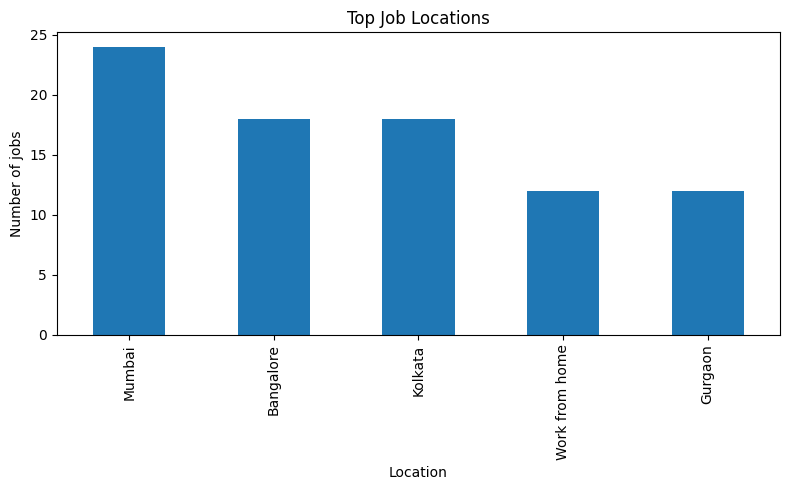

Saved skills pie chart to: top_skills_20250916_142839.png


<Figure size 600x600 with 0 Axes>

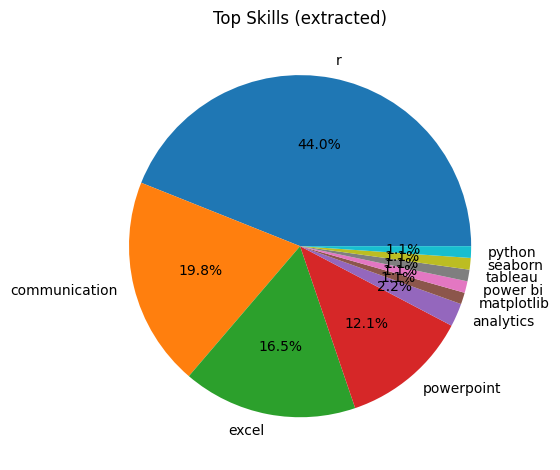

In [23]:
def main():
    # Try scraping
    try:
        print("Attempting to scrape Internshala...")
        df_scraped = scrape_internshala(PAGES_TO_SCRAPE)
        if df_scraped.empty:
            raise ValueError("Scraped dataframe is empty.")
        df_scraped = clean_dataframe(df_scraped)
        # Save CSV
        df_scraped.to_csv(OUTPUT_CSV, index=False)
        print(f"\nScraped data saved to: {OUTPUT_CSV}")
        analyze_and_plot(df_scraped)
    except requests.exceptions.HTTPError as he:
        print(f"\nHTTP error during scraping: {he}", file=sys.stderr)
        if USE_MOCK_ON_FAIL:
            print("Falling back to mock dataset.")
            df_mock = generate_mock_data(60)
            df_mock.to_csv(OUTPUT_CSV, index=False)
            print(f"Mock data saved to: {OUTPUT_CSV}")
            analyze_and_plot(df_mock)
        else:
            print("Exiting due to scraping error.")
            sys.exit(1)
    except Exception as e:
        # Generic fallback: show mock dataset so analysis can still run
        print(f"\nUnexpected scraping error: {e}", file=sys.stderr)
        if USE_MOCK_ON_FAIL:
            print("Falling back to mock dataset.")
            df_mock = generate_mock_data(60)
            df_mock.to_csv(OUTPUT_CSV, index=False)
            print(f"Mock data saved to: {OUTPUT_CSV}")
            analyze_and_plot(df_mock)
        else:
            raise


if __name__ == "__main__":
    main()